---
title: "practice 3"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: false
    code-summary: "Show the code"
---

Here we will find the tempo of a song.  
First let's listen to the song:

<audio controls="controls"><source src="stayin_alive.wav" type="audio/wav" /></audio>

[Link](https://www.youtube.com/watch?v=fNFzfwLM72c) to the full song on youtube.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.io import wavfile
import math
import scipy
from scipy.signal import find_peaks

# %matplotlib widget

Import audio timeseries

In [2]:
samplerate, audio_stereo = wavfile.read('stayin_alive.wav')
audio = audio_stereo[:, 0]

Standardize and plot.

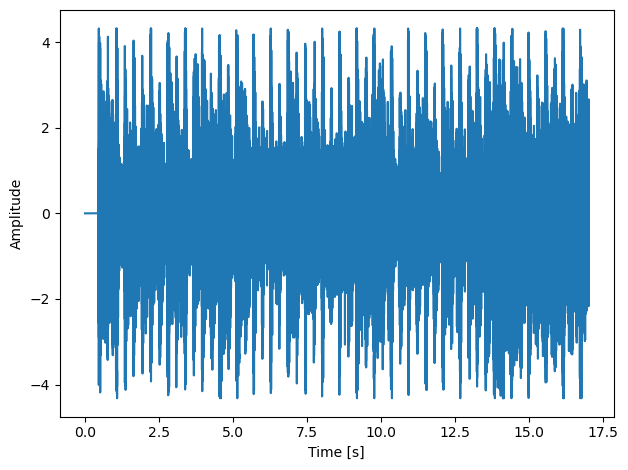

In [ ]:
audio = (audio - np.mean(audio))/np.std(audio)
length = audio.shape[0] / samplerate
time = np.linspace(0., length, audio.shape[0])

fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")

plt.tight_layout()

Let's see what is the sample rate of the song, that is, how many data points we have per second.

In [4]:
samplerate

48000

## apply FFT

In [5]:
dt = 1/samplerate
t = time
N = audio.shape[0]
x = audio

In [6]:
fft = scipy.fft.fft(x) / N
k = scipy.fft.fftfreq(N, dt)
fft_abs = np.abs(fft)

keep only positive k values

In [7]:
fft_abs = fft_abs[k>=0]
k = k[k>=0]

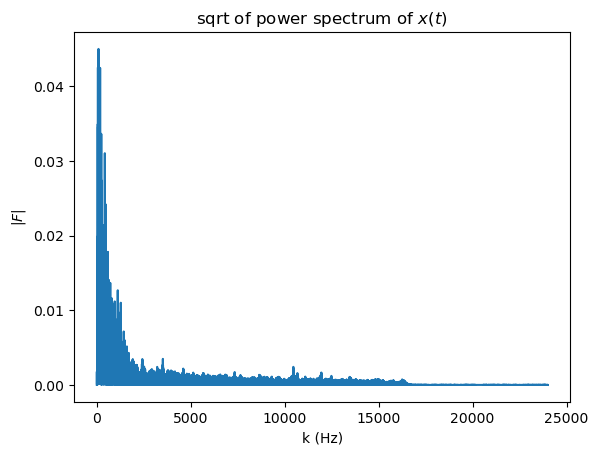

In [8]:
fig, ax = plt.subplots()
ax.plot(k, fft_abs)
ax.set(xlabel="k (Hz)",
       ylabel="$|F|$",
       title="sqrt of power spectrum of $x(t)$");

The relevant frequency spectrum for tempo is very low in the 0.5-6 Hz range. Think about it, a clock ticks at 1 Hz, that will be like a slow song. Double that speed will be 2 Hz. Actually, in the music world we don't talk in Hz when dealing with tempo, we use beats per minute (bpm) instead. A clock ticks at 60 bpm, a song double that speed will be at 120 bpm. The conversion factor from Hz to bpm is simple, 1Hz $=$ 60 bpm. So let's zoom in to that range:

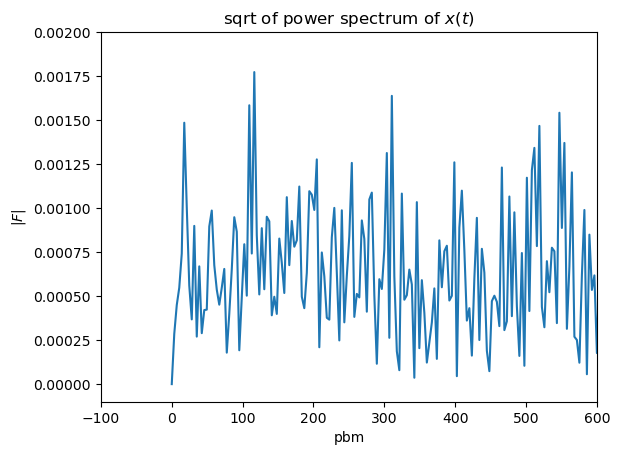

In [ ]:
bpm = k*60
fig, ax = plt.subplots()
ax.plot(bpm, fft_abs)
ax.set(xlabel="pbm",
       ylabel="$|F|$",
       title="sqrt of power spectrum of $x(t)$");
ax.set_xlim(-100,600);
ax.set_ylim(-0.0001,0.002);

We don't see any significant peak. That is because the samplerate is very high and it is picking on the actual notes that are being played at every beat making the peak not clear. Lets filter the timeseries to show the beat peaks more clearly. We will do that by resampling the max values of stagered pools of values.

In [10]:
factor = 200
data_reshaped = audio.reshape(int(len(audio)/factor), factor)
max_values = np.max(data_reshaped, axis=1)
max_values = (max_values - np.mean(max_values))/np.std(max_values)
new_samplerate = samplerate/factor
N = max_values.shape[0]
new_length = N / new_samplerate
new_time = np.linspace(0., new_length, N)

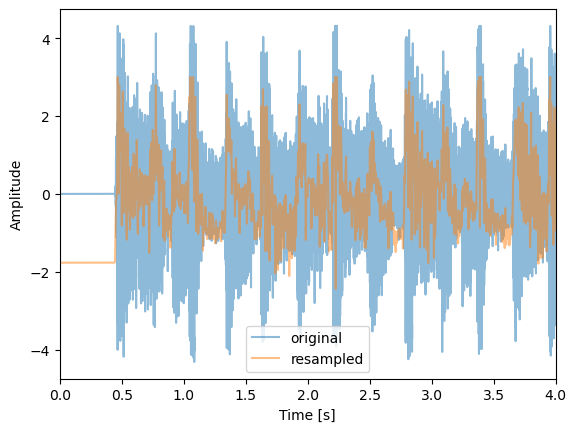

In [11]:
fig, ax = plt.subplots()
ax.plot(time, audio, alpha=0.5, label='original')
ax.plot(new_time, max_values, alpha=0.5,label='resampled')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.set_xlim(0,4)
ax.legend()

## Apply FFT on resampled timeseries

In [12]:
dt = 1/new_samplerate
t = new_time
x = max_values

In [13]:
fft = scipy.fft.fft(x) / N
k = scipy.fft.fftfreq(N, dt)
fft_abs = np.abs(fft)

fft_abs = fft_abs[k>=0]
k = k[k>=0]

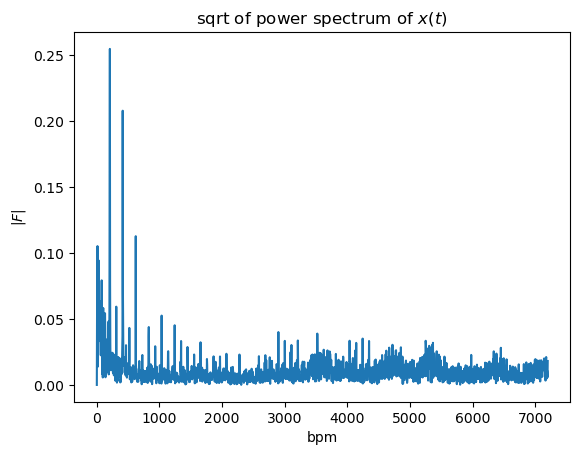

In [14]:
bpm = k*60
fig, ax = plt.subplots()
ax.plot(bpm, fft_abs)
ax.set(xlabel="bpm",
       ylabel="$|F|$",
       title=r"sqrt of power spectrum of $x(t)$");

Lets zoom into the relevant range:

Highest peak at 208.24 bpm


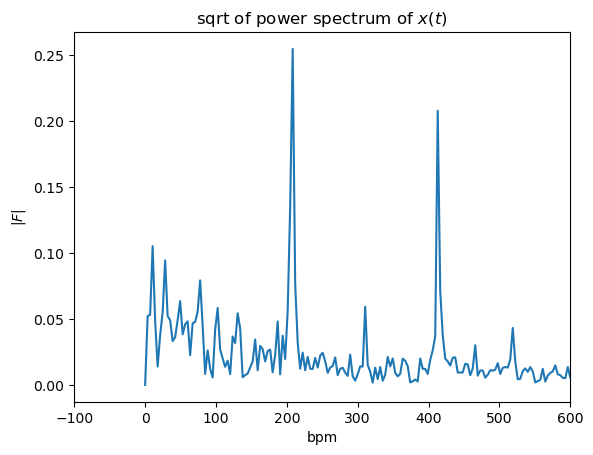

In [15]:
bpm = k*60
fig, ax = plt.subplots()
ax.plot(bpm, fft_abs)
ax.set(xlabel="bpm",
       ylabel="$|F|$",
       title=r"sqrt of power spectrum of $x(t)$");
ax.set_xlim(-100,600);
print(f'Highest peak at {bpm[fft_abs.argmax()]:.2f} bpm')

We got a strong peak on `208.24 pbm`.  
Let's check what is the "agreed" bpm of the song, we will do it in two ways:

1. google search: [stayin alive bpm](https://letmegooglethat.com/?q=stayin+alive+bpm){target="_blank"}
1. using the site [bpmfinder](https://bpmfinder.app/result/fNFzfwLM72c){target="_blank"} that computes the pbm for a given youtube link. They don't use fft, you can read about their method [here](https://bpmfinder.app/how-it-works){target="_blank"}.